In [1]:
import os

import numpy as np
import pandas as pd
import polars as pl

In [2]:
cwd = os.getcwd()
cwd, _ = os.path.split(cwd)
cwd

'/Users/fynn/Uni/MA'

In [3]:
import tensorflow as tf
from tensorflow import keras

BATCH_SIZE = 100000
samples = os.path.join(cwd, "data", "2D", "MIP")
class_names = ["solved", "interrupted"]

train_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "training",
    follow_links = False
)

val_dataset = keras.preprocessing.text_dataset_from_directory(
    directory = samples,
    labels = "inferred",
    label_mode = "binary",
    class_names = class_names,
    batch_size = BATCH_SIZE,
    max_length = None,
    shuffle = True,
    seed = 3093453,
    validation_split = 0.2,
    subset = "validation",
    follow_links = False
)

class_names = np.array(["solved", "interrupted"])

Found 165776 files belonging to 2 classes.
Using 132621 files for training.


2023-10-20 15:30:00.860981: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-20 15:30:00.861040: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-20 15:30:00.861044: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-20 15:30:00.861115: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-20 15:30:00.861142: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 165776 files belonging to 2 classes.
Using 33155 files for validation.


In [4]:
for X,y in train_dataset.take(1):
    pass

In [5]:
y = pd.Series(X.numpy().astype(str)).str.extractall("MIP Improvement( )")
y = y.groupby(y.index.get_level_values(0)).count().to_numpy()[:,0]
y = y == 1

In [6]:
print(X.numpy().astype(str)[0])

dataset: A
instance: DO2
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P252045203
Stack 0 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 1 with items: ['0090019100_03072022000050', '0090019100_03072022000050', '0090019100_03072022000050']
Stack 2 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 3 with items: ['0090019100_03072022004580', '0090019100_03072022004580', '0090019100_03072022004580']
Stack 4 with items: ['0090019100_03072022004580', '0090019100_03072022004580', '0090019100_03072022004580']
Stack 5 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 6 with items: ['0090019100_03072022000050', '0090019100_03072022000050', '0090019100_03072022000050']
Stack 7 with items: ['0090019100_03072022006982', '0090019100_03072022006982']
Stack 8 with items: ['0090019100_03072022005313', '0090019100_030720

In [7]:
X = X.numpy().astype(str)
df = pl.DataFrame({"raw": X})
print(df[0, 0])

dataset: A
instance: DO2
+-----------+
2D Packing MIP with Time Limit 30 [s] in Truck P252045203
Stack 0 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 1 with items: ['0090019100_03072022000050', '0090019100_03072022000050', '0090019100_03072022000050']
Stack 2 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 3 with items: ['0090019100_03072022004580', '0090019100_03072022004580', '0090019100_03072022004580']
Stack 4 with items: ['0090019100_03072022004580', '0090019100_03072022004580', '0090019100_03072022004580']
Stack 5 with items: ['0090019100_03072022006855', '0090019100_03072022006855', '0090019100_03072022006855']
Stack 6 with items: ['0090019100_03072022000050', '0090019100_03072022000050', '0090019100_03072022000050']
Stack 7 with items: ['0090019100_03072022006982', '0090019100_03072022006982']
Stack 8 with items: ['0090019100_03072022005313', '0090019100_030720

# Processing functions:

## Extract raw data

In [8]:
def extract_raw_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extracts features via regex from raw txt-file input.
    Drops rows which dont contain a truck_id or 3D packing instances
    """
    df = df.with_columns([
        pl.Series(name="index", values=np.arange(len(df.collect()))),
        #pl.Series(name="index", values=np.arange(len(df))),
        pl.col("raw").str.extract("in Truck (\w\d{9})\n").alias("truck_id"),
        pl.col("raw").str.extract("dataset: (\w*)\n").alias("dataset"),
        pl.col("raw").str.extract("instance: ([A-Z0-9]*)\n").alias("instance"),
    ])
    
    return df


In [9]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .collect()
    .head()
)

raw,index,truck_id,dataset,instance
str,i64,str,str,str
"""dataset: A ins…",0,"""P252045203""","""A""","""DO2"""
"""dataset: C ins…",1,"""P089235505""","""C""","""SA"""
"""dataset: C ins…",2,"""P104425503""","""C""","""TR3"""
"""dataset: X ins…",3,"""P178752701""","""X""","""AS2"""
"""dataset: X ins…",4,"""P174752701""","""X""","""AS2"""


## Explode instance into stacks:

In [10]:
def explode_instances_into_stacks(df: pl.LazyFrame) -> pl.DataFrame:
    """
    Use regex to extract all stacks made of item ids, and explode df
    into rows of stacks, belonging to an instance.
    """
    
    df = (
        df.with_columns([
            pl.col("raw").str.extract_all("Stack \d* with items: (\[.*\])\n").alias("stacks")
        ])
          .drop(["raw"])
          .explode(columns = ["stacks"])\
          .with_columns([
              pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
              pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
          ])
    )
    return df


In [11]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stacks,stack_id,item_id
i64,str,str,str,str,i64,list[str]
0,"""P252045203""","""A""","""DO2""","""Stack 0 with i…",0,"[""0090019100_03072022006855"", ""0090019100_03072022006855"", ""0090019100_03072022006855""]"
0,"""P252045203""","""A""","""DO2""","""Stack 1 with i…",1,"[""0090019100_03072022000050"", ""0090019100_03072022000050"", ""0090019100_03072022000050""]"
0,"""P252045203""","""A""","""DO2""","""Stack 2 with i…",2,"[""0090019100_03072022006855"", ""0090019100_03072022006855"", ""0090019100_03072022006855""]"
0,"""P252045203""","""A""","""DO2""","""Stack 3 with i…",3,"[""0090019100_03072022004580"", ""0090019100_03072022004580"", ""0090019100_03072022004580""]"
0,"""P252045203""","""A""","""DO2""","""Stack 4 with i…",4,"[""0090019100_03072022004580"", ""0090019100_03072022004580"", ""0090019100_03072022004580""]"


## Explode stacks into items:

In [12]:
def explode_stacks_into_items(df: pl.DataFrame) -> pl.DataFrame:
    """
    Use regex to identify a stack and explode it into items,
    belonging to a stack, which again belongs to an instance.
    """
    df = df.with_columns([
        pl.col("stacks").str.extract("Stack (\d*) with").cast(pl.Int64, strict=False).alias("stack_id"),
        pl.col("stacks").str.extract_all("(\d{10}_\d{14})").alias("item_id")
    ]).drop("stacks").explode("item_id")\
    
    return df

In [13]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .collect()
    #.head()
)

index,truck_id,dataset,instance,stack_id,item_id
i64,str,str,str,i64,str
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",1,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",1,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",1,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",2,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",2,"""0090019100_030…"
0,"""P252045203""","""A""","""DO2""",2,"""0090019100_030…"


## Load and Merge Items

In [14]:
folder = "truck-item-infos"
file = "items.csv"

item_path = os.path.join(cwd, folder, file)
items = pl.read_csv(source = item_path);

items = items.lazy().with_columns([
    (pl.col("Item ident").alias("item_id")),
    (pl.col("Length") / 1000), # mm to m
    (pl.col("Width") / 1000),  # mm to m
    (pl.col("Height") / 1000), # mm to m
    (pl.col("Nesting height") / 1000), # mm to m
    (pl.col("Weight") / 1000), # kg to tons
    (pl.col("Forced orientation") == "lengthwise").alias("ForcedLength"),
    (pl.col("Forced orientation") == "widthwise").alias("ForcedWidth"),
    ((pl.col("Height") - pl.col("Nesting height")) / 1000).alias("NestedHeight"),
    pl.col("dataset").str.extract("([A-Z])")
]).drop([
    "Forced orientation", "Max stackability", "Inventory cost",
    "Earliest arrival time", "Latest arrival time", "Number of items",
    "instance_id",
    "Stackability code",
    "Item ident" # drop because of rename earlier
]).unique()

items.collect().head()

Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,dataset,instance,item_id,ForcedLength,ForcedWidth,NestedHeight
i64,str,i64,str,str,str,f64,f64,f64,f64,f64,str,str,str,bool,bool,f64
1925700,null,90016900,"""GRF1""","""682116715R""","""SFDA--9767""",1.2,1.0,0.975,0.1463,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
2573225,null,90016900,"""GRF1""","""259971716R""","""CON-S-0130""",0.78,0.57,0.478,0.04088,0.047,"""C""","""BY""","""0090016900_270…",false,true,0.431
21798202,null,90016900,"""GRD1""","""144605995R""","""SLI---0770""",1.2,1.0,0.975,0.181,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.93
1925700,null,90016900,"""GRF1""","""684305630R""","""KFDA--0047""",1.209,1.007,0.75,0.120524,0.025,"""C""","""BY""","""0090016900_270…",false,false,0.725
22060301,null,90016900,"""169GB-10""","""8200784370""","""SLI---0760""",1.2,1.0,0.93,0.18548,0.045,"""C""","""BY""","""0090016900_270…",false,false,0.885


In [15]:
def join_items(df: pl.DataFrame, items) -> pl.DataFrame:
    """
    Perform a simple left join to add item level info.
    
    Validation sadly not supported for multiple keys (yet?)
    """
    
    return df.join(items, how = "left", on = ["dataset", "instance", "item_id"])

In [16]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .collect()
    .head()
)

index,truck_id,dataset,instance,stack_id,item_id,Supplier code,Supplier dock,Plant code,Plant dock,Product code,Package code,Length,Width,Height,Weight,Nesting height,ForcedLength,ForcedWidth,NestedHeight
i64,str,str,str,i64,str,i64,str,i64,str,str,str,f64,f64,f64,f64,f64,bool,bool,f64
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…",5706100,null,90019100,"""191GY-""","""673520819R""","""SLI---0770""",1.2,1.0,0.975,0.12798,0.045,false,false,0.93
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…",5706100,null,90019100,"""191GY-""","""673520819R""","""SLI---0770""",1.2,1.0,0.975,0.12798,0.045,false,false,0.93
0,"""P252045203""","""A""","""DO2""",0,"""0090019100_030…",5706100,null,90019100,"""191GY-""","""673520819R""","""SLI---0770""",1.2,1.0,0.975,0.12798,0.045,false,false,0.93
0,"""P252045203""","""A""","""DO2""",1,"""0090019100_030…",5706100,null,90019100,"""191GY-""","""543217104R""","""SLI---0770""",1.2,1.0,0.975,0.12924,0.045,false,false,0.93
0,"""P252045203""","""A""","""DO2""",1,"""0090019100_030…",5706100,null,90019100,"""191GY-""","""543217104R""","""SLI---0770""",1.2,1.0,0.975,0.12924,0.045,false,false,0.93


## Group by stack ID:

In [17]:
def group_items_by_stack(df: pl.DataFrame) -> pl.DataFrame:
    """
    Group item level into back into a stack
    
    - Note that the Width and Length are the same for all items
    - Weight and Height have to be summed up, correcting for nesting height
    - forcedOrientation of a single item makes the whole stack oriented
    - Include Logistics info for stop differentation down the road
    
    """
    
    df = df.group_by(["index", "dataset", "instance", "truck_id", "stack_id"],
                    maintain_order = True)\
    .agg([
        pl.count("item_id").alias("items"),
        pl.max("Length"),
        pl.max("Width"),
        pl.sum("NestedHeight"),
        pl.last("Nesting height"),
        pl.sum("Weight"),
        pl.any("ForcedLength"),
        pl.any("ForcedWidth"),
        # Logistic order info
        pl.first("Supplier code"),
        pl.first("Supplier dock"),
        pl.first("Plant dock")
    ]).sort(["index", "stack_id"]).drop(["stack_id"])

    return df

In [18]:
(
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
# (507_770, 7)

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38772,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.3834,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.3834,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38772,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",2,1.2,1.0,1.86,0.045,0.8604,false,false,7235905,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",2,1.2,1.0,1.86,0.045,0.9124,false,false,7235905,null,"""191GY-"""


# Data Vis:

## Data Prep

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="talk",
        style="darkgrid")

In [20]:
X = (
    df.lazy()
    .pipe(extract_raw_data)
    .pipe(explode_instances_into_stacks)
    .pipe(explode_stacks_into_items)
    .pipe(join_items, items)
    .pipe(group_items_by_stack)
    .collect()
    #.head()
)
X

index,dataset,instance,truck_id,items,Length,Width,NestedHeight,Nesting height,Weight,ForcedLength,ForcedWidth,Supplier code,Supplier dock,Plant dock
i64,str,str,str,u32,f64,f64,f64,f64,f64,bool,bool,i64,str,str
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38772,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.3834,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.3834,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38394,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",3,1.2,1.0,2.79,0.045,0.38772,false,false,5706100,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",2,1.2,1.0,1.86,0.045,0.8604,false,false,7235905,null,"""191GY-"""
0,"""A""","""DO2""","""P252045203""",2,1.2,1.0,1.86,0.045,0.9124,false,false,7235905,null,"""191GY-"""


## 2x2 Stacks and items

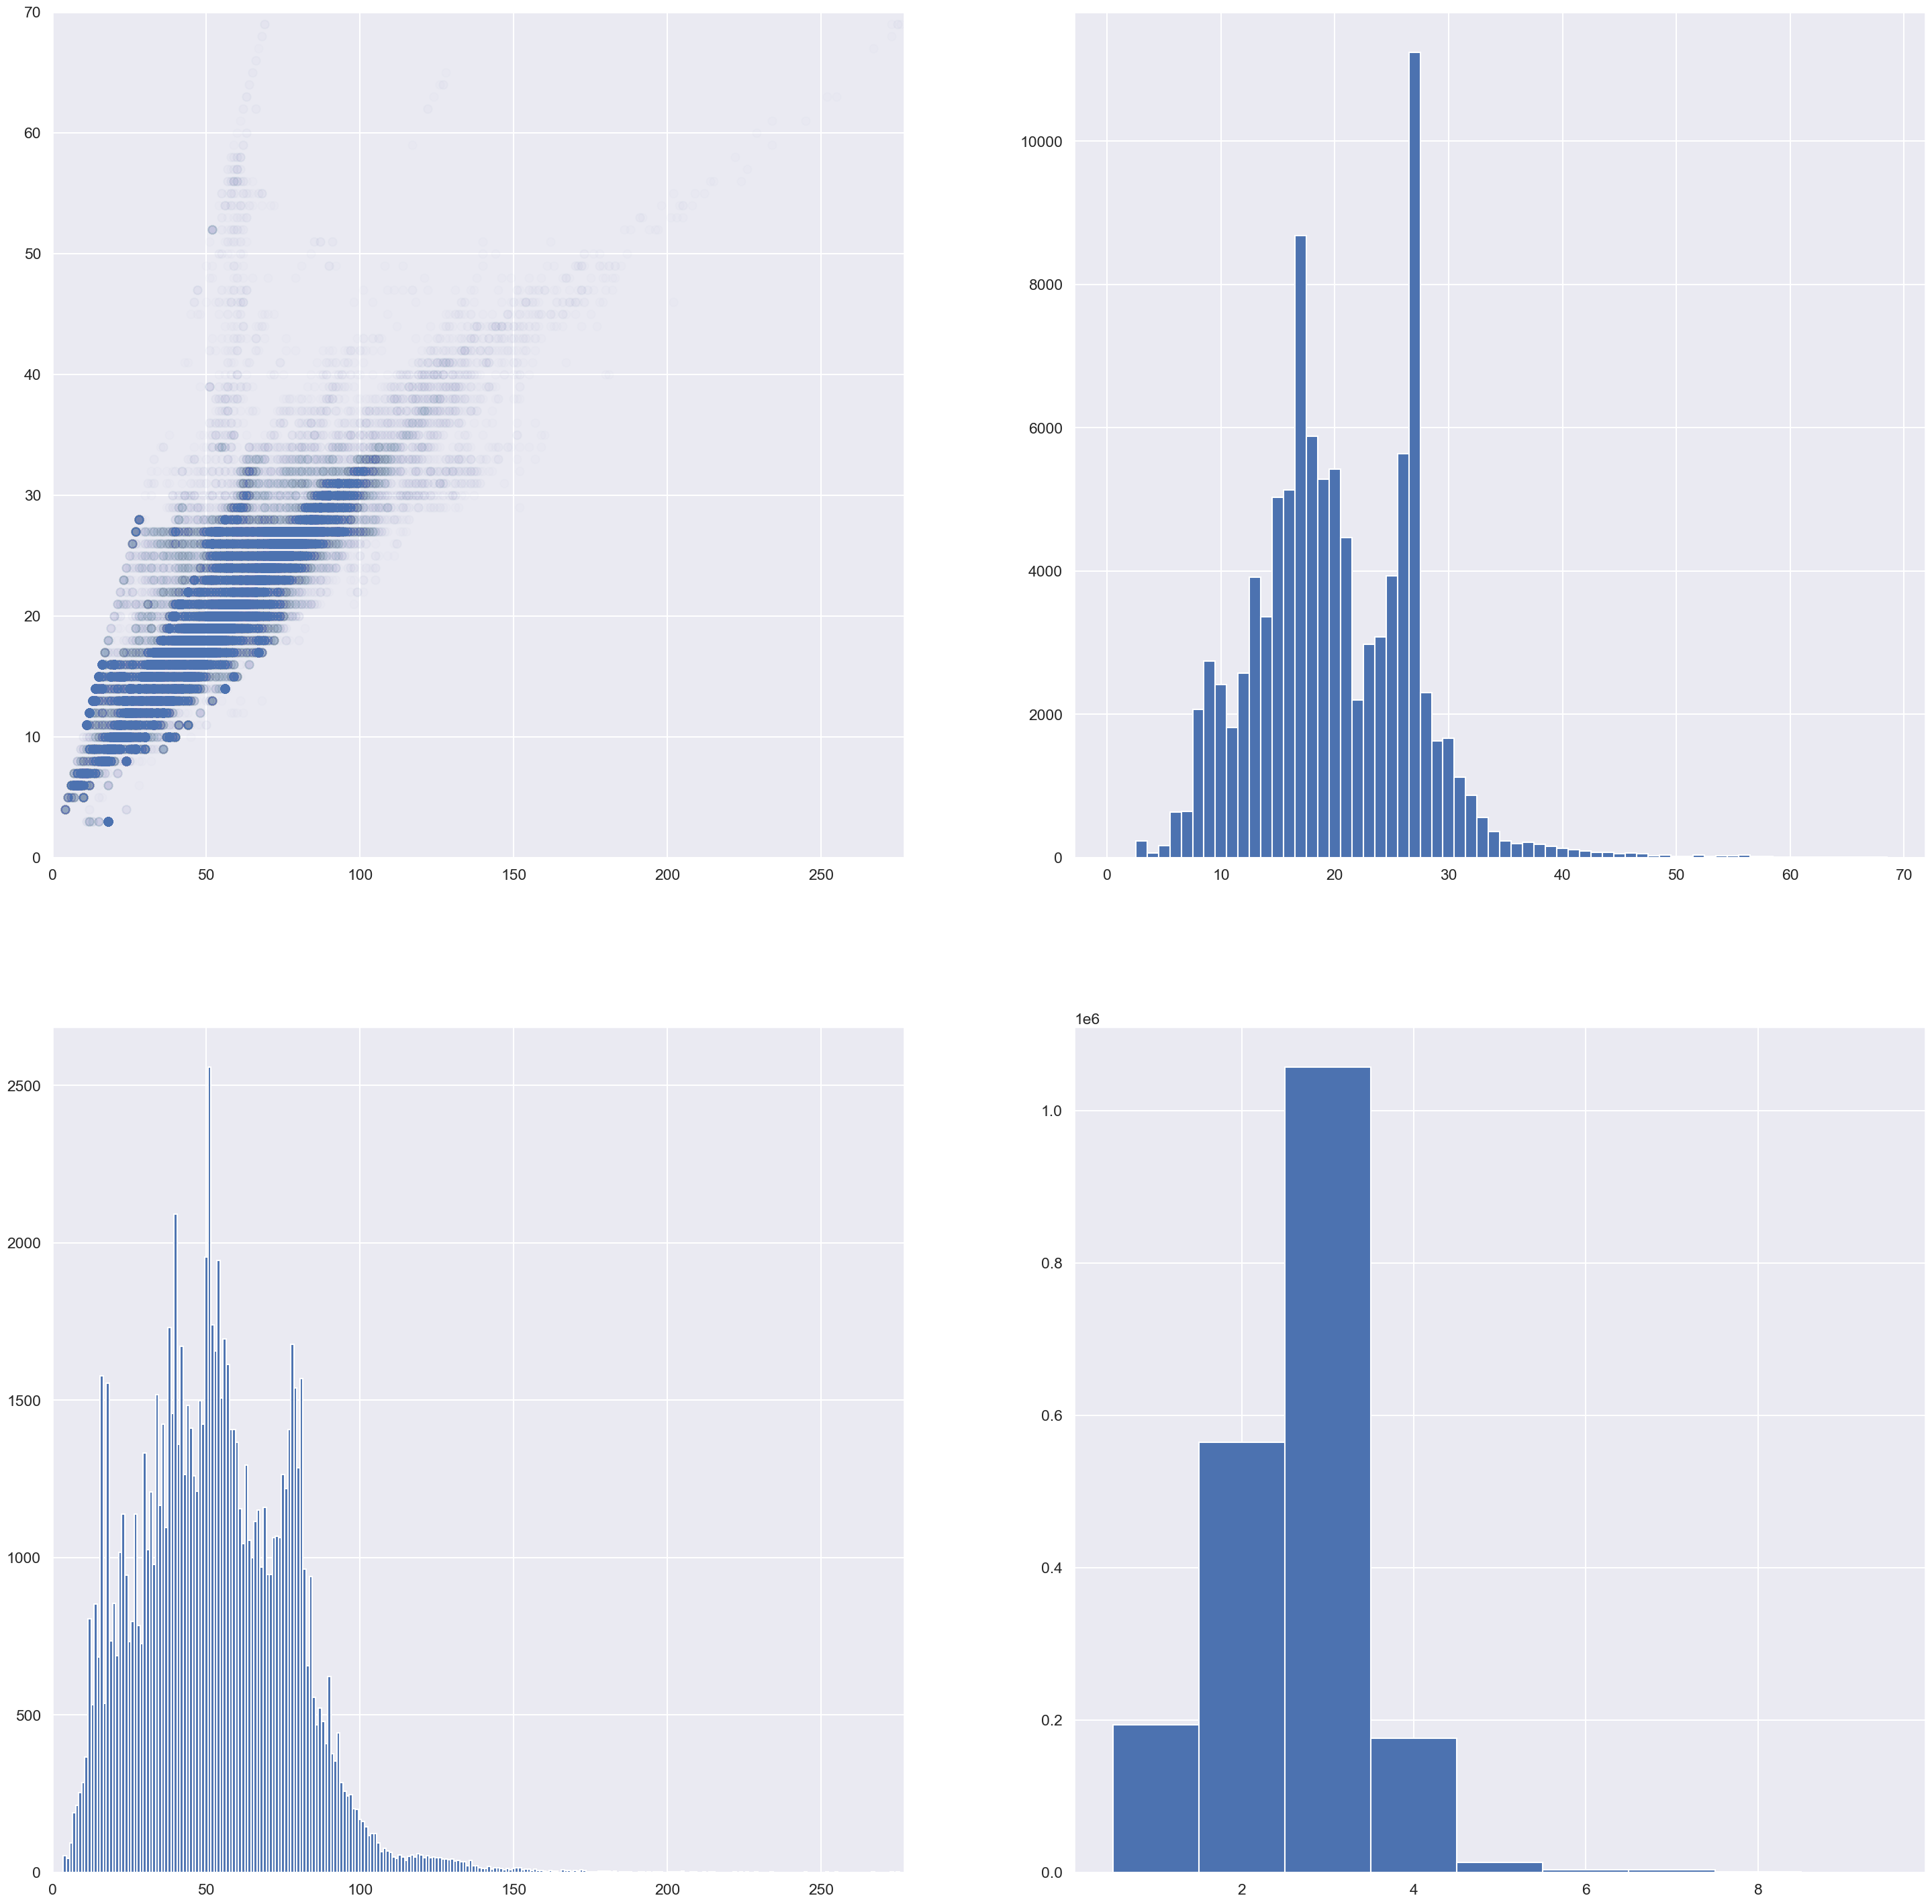

In [21]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

item_max = x.max()[0, "total_items"]
stack_max = x.max()[0, "total_stacks"]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (36, 36))



ax[0, 0].scatter(
    y=x["total_stacks"],
    x=x["total_items"],
    #c = y.numpy(),
    alpha = 0.01
);
ax[0, 0].set(xlim=[0, item_max+1])
ax[0, 0].set(ylim=[0, stack_max+1])

ax[0, 1].hist(x["total_stacks"], bins=np.arange(0, stack_max, 1)+0.5)

ax[1, 0].hist(x["total_items"], bins=np.arange(0, item_max, 1)+0.5)
ax[1, 0].set(xlim=[0, item_max+1])



x = X["items"].to_numpy()
ax[1, 1].hist(x, bins=np.arange(0, 10, 1)+0.5);


## MIP Improvements:

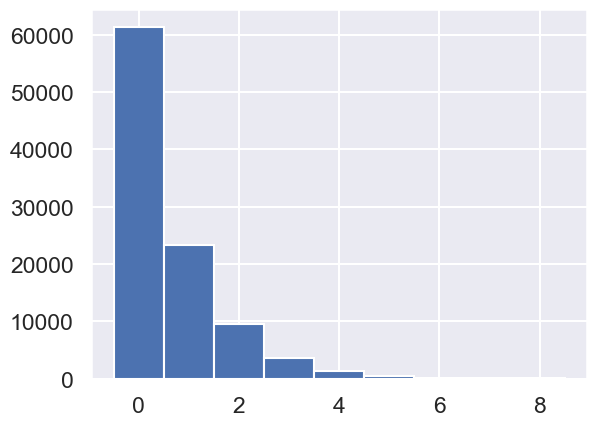

In [22]:
# Number of MIP Improvements:
x = df["raw"].str.extract_all("MIP Improvement (-)").list.len().to_pandas()
x = x-1
x.hist(bins = np.arange(0, 10, 1)-0.5);

raw
list[str]
"[""MIP Improvement - 2D Vol: 30.72 [m2] - packed 2D Vol Ratio: 0.9326047358834244 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.92 [m2] - packed 2D Vol Ratio: 0.9690346083788708 [%] - after 18.17896318435669 [s]""]"
"[""MIP Improvement - 2D Vol: 31.21806 [m2] - packed 2D Vol Ratio: 0.9477249544626595 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.2181 [m2] - packed 2D Vol Ratio: 0.9477261687917427 [%] - after 3.9993929862976074 [s]""]"
"[""MIP Improvement - 2D Vol: 31.01418 [m2] - packed 2D Vol Ratio: 0.9415355191256831 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.0142 [m2] - packed 2D Vol Ratio: 0.9415361262902247 [%] - after 5.2376549243927 [s]""]"
"[""MIP Improvement - 2D Vol: 33.6 [m2] - packed 2D Vol Ratio: 0.8995983935742972 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 33.6 [m2] - packed 2D Vol Ratio: 0.8995983935742972 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 30.10938 [m2] - packed 2D Vol Ratio: 0.9140673952641167 [%] - after 0.0 [s]""]"
"[""MIP Improvement - 2D Vol: 30.05418 [m2] - packed 2D Vol Ratio: 0.912391621129326 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 30.0542 [m2] - packed 2D Vol Ratio: 0.9123922282938678 [%] - after 0.5302350521087646 [s]"", ""MIP Improvement - 2D Vol: 31.27224 [m2] - packed 2D Vol Ratio: 0.9493697632058289 [%] - after 0.7124079121276736 [s]""]"
"[""MIP Improvement - 2D Vol: 30.76207 [m2] - packed 2D Vol Ratio: 0.9338819064966607 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 30.7621 [m2] - packed 2D Vol Ratio: 0.9338828172434731 [%] - after 0.5759198665618896 [s]"", … ""MIP Improvement - 2D Vol: 31.4961 [m2] - packed 2D Vol Ratio: 0.9561657559198543 [%] - after 4.596377849578857 [s]""]"
"[""MIP Improvement - 2D Vol: 28.8 [m2] - packed 2D Vol Ratio: 0.8743169398907105 [%] - after 0.0 [s]"", ""MIP Improvement - 2D Vol: 31.2 [m2] - packed 2D Vol Ratio: 0.947176684881603 [%] - after 0.027109304908663034 [s]""]"


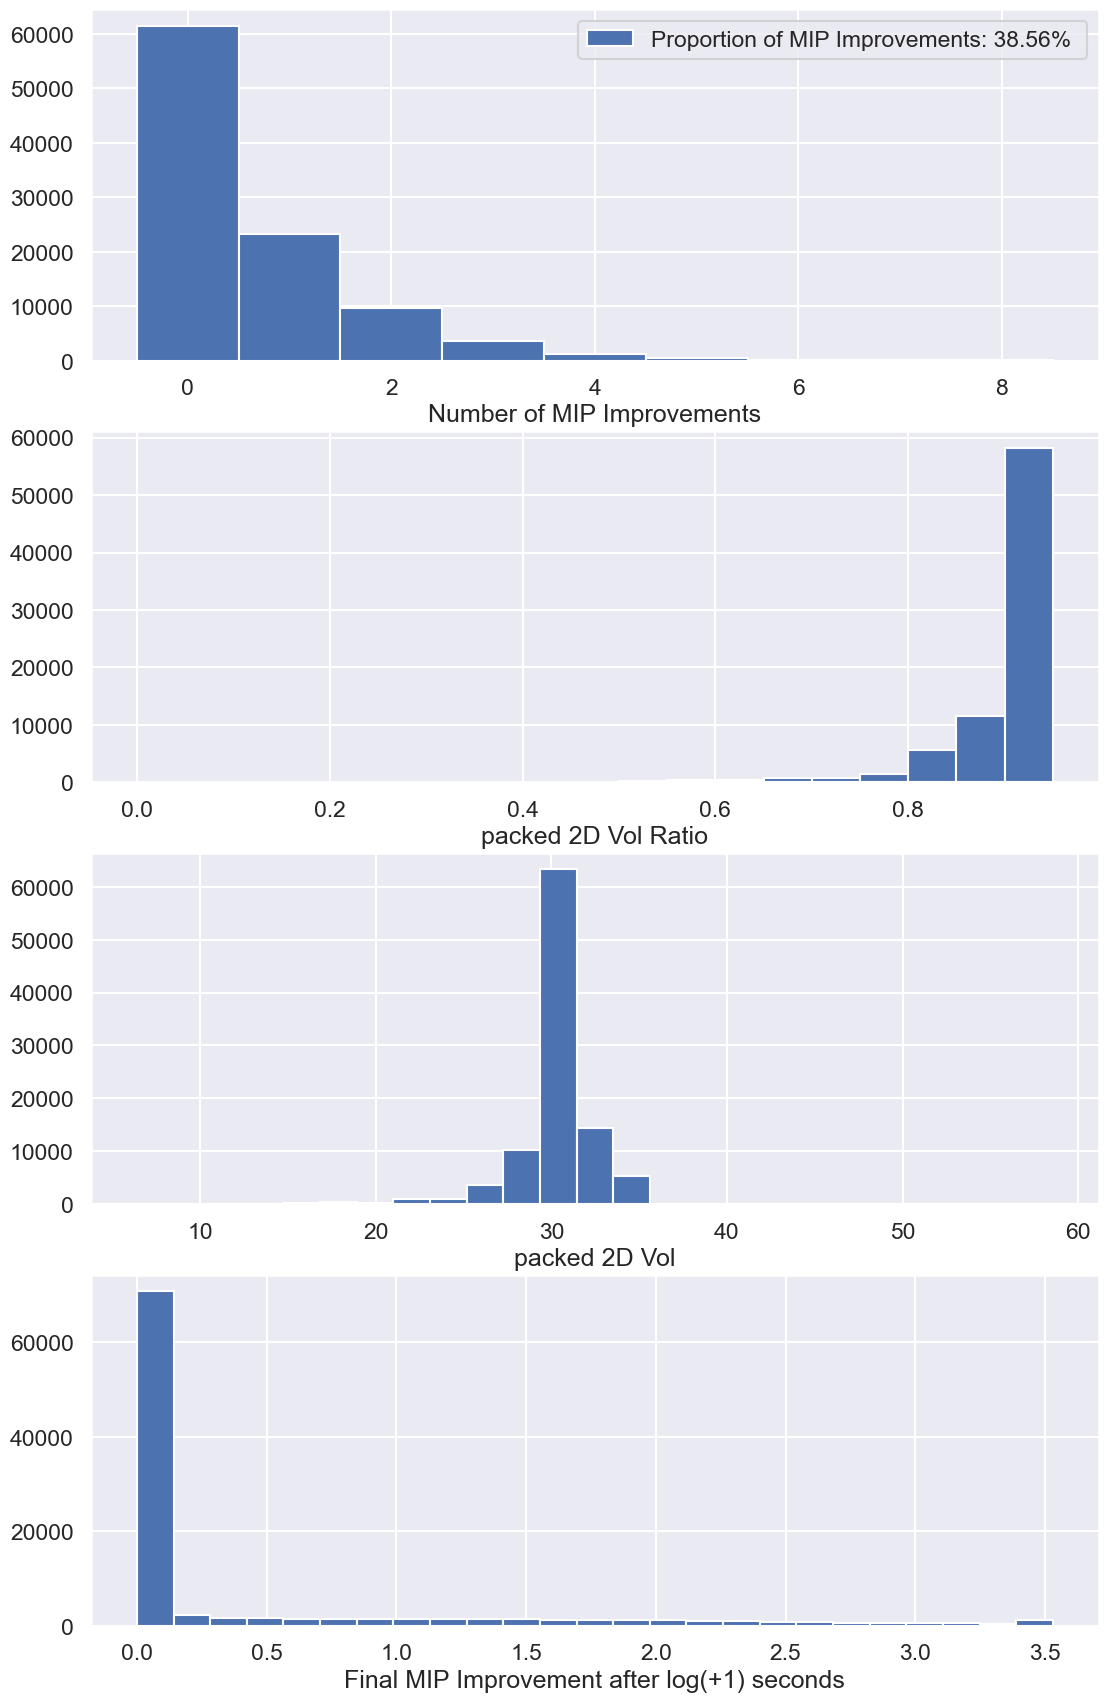

In [23]:
pattern = "MIP Improvement - 2D Vol: \d*\.\d* \[m2\] - packed 2D Vol Ratio\: \d*\.\d* \[\%\] - after \d*\.\d* \[s\]"
mip_improvements = df["raw"].str.extract_all(pattern)#.list[-1][2]

fig, ax = plt.subplots(4, figsize = (13, 21))

y_num_improvements = mip_improvements.list.len()-1
ax[0].hist(y_num_improvements, bins = np.arange(0, 10, 1)-0.5,
           label=f"Proportion of MIP Improvements: {(y_num_improvements>0).mean():.2%} ");
ax[0].set(xlabel="Number of MIP Improvements")

y_packed_area_ratio = mip_improvements.list[-1].str.extract("\: (\d*\.\d*) \[\%\]").cast(pl.Float32)
ax[1].hist(y_packed_area_ratio, bins = np.arange(0, 1, 0.05));
ax[1].set(xlabel="packed 2D Vol Ratio")

#ax[2].hist((y_packed_area_ratio)**10, bins = 25);
#ax[2].set(xlabel="packed 2D Vol Ratio to the power 10")

y_packed_area = mip_improvements.list[-1].str.extract("- 2D Vol: (\d*\.\d*) \[m2\]").cast(pl.Float32)
ax[2].hist(y_packed_area, bins = 25);
ax[2].set(xlabel="packed 2D Vol")


y_last_update = mip_improvements.list[-1].str.extract("- after (\d*\.\d*) \[s\]").cast(pl.Float32)
ax[3].hist(np.log1p(y_last_update), bins = 25);
ax[3].set(xlabel="Final MIP Improvement after log(+1) seconds")


ax[0].legend()

#mip_improvements

In [24]:
print(df[1,0])

dataset: C
instance: SA
+-----------+
2D Packing MIP with Time Limit 7.370717380217505 [s] in Truck P089235505
Stack 0 with items: ['0090017100_27022023033144', '0090017100_27022023033144']
Stack 1 with items: ['0090017100_27022023033144', '0090017100_27022023033144']
Stack 2 with items: ['0090017100_27022023033144', '0090017100_27022023033144']
Stack 3 with items: ['0090017100_27022023033144', '0090017100_27022023033144']
Stack 4 with items: ['0090017100_27022023033144', '0090017100_27022023033144']
Stack 5 with items: ['0090017100_27022023033144', '0090017100_27022023007598']
Stack 6 with items: ['0090017100_27022023007598', '0090017100_27022023007598']
Stack 7 with items: ['0090017100_27022023007598', '0090017100_27022023007598']
Stack 8 with items: ['0090017100_27022023007598', '0090017100_27022023007598']
Stack 9 with items: ['0090017100_27022023007598', '0090017100_27022023007598']
Stack 10 with items: ['0090017100_27022023001771', '0090017100_27022023001771']
Stack 11 with items

## Missing Stacks

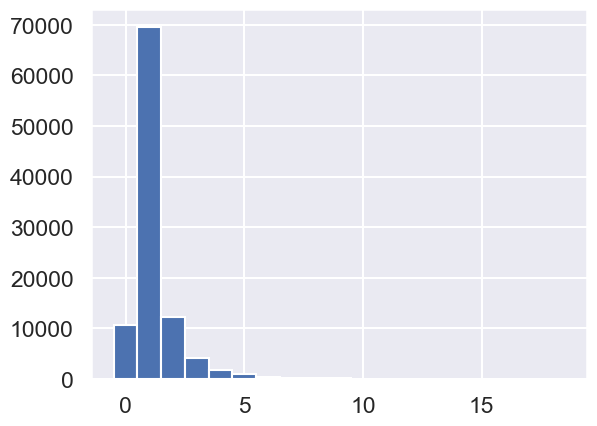

In [25]:
pattern = "Stack (\d*) not in final solution with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
x = df["raw"].str.extract_all(pattern).map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
plt.hist(x.list.len(), bins=np.arange(0, 20, 1)-0.5);
#Number of missing items in final solution:

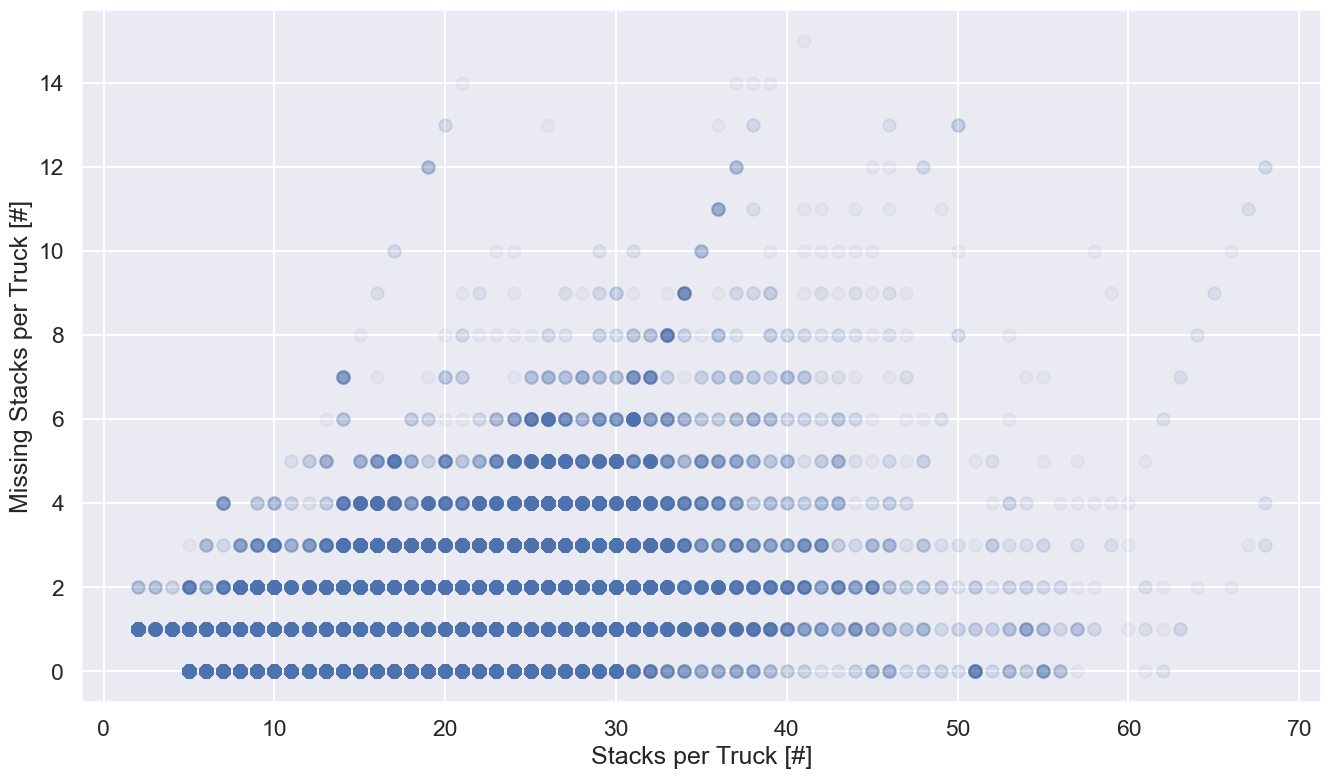

In [26]:
pattern = "Stack (\d*) with items:"
#df["raw"].str.extract_all(pattern).apply(lambda x: [i.split(" ")[1] for i in x])
y = df["raw"].str.extract_all(pattern)#.map_elements(lambda x: [int(i.split(" ")[1]) for i in x])
y = y.map_elements(lambda x: max(int(i.split(" ")[1]) for i in x))

plt.figure(figsize=(16, 9))
plt.scatter(y, x.list.len(), alpha=0.05);
plt.xlabel("Stacks per Truck [#]")
plt.ylabel("Missing Stacks per Truck [#]");

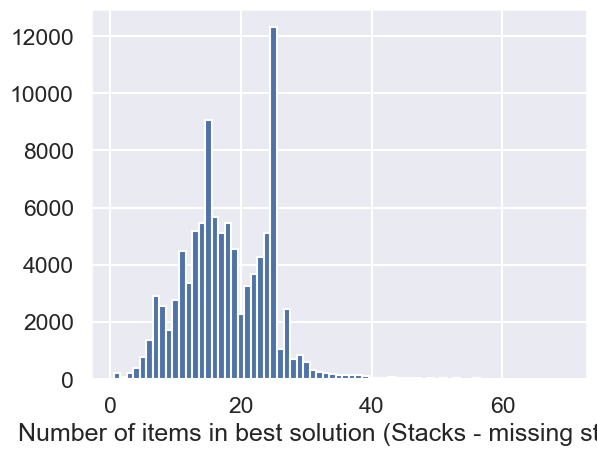

In [27]:
plt.hist(y-x.list.len(), bins=np.arange(0, 70, 1)+0.5);
plt.xlabel("Number of items in best solution (Stacks - missing stacks)");

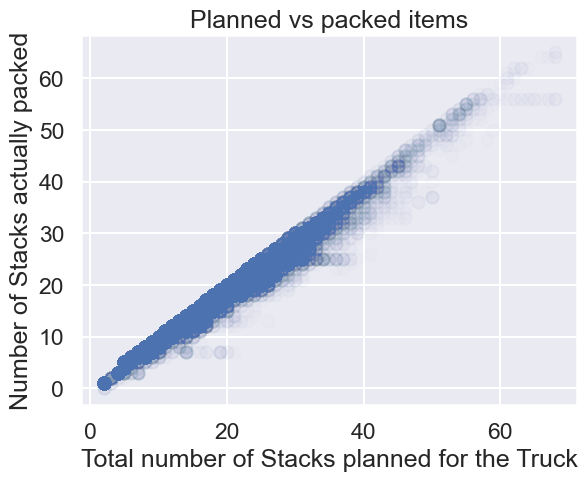

In [28]:
plt.scatter(y, y-x.list.len(), alpha=0.01);
plt.title("Planned vs packed items");
plt.xlabel("Total number of Stacks planned for the Truck")
plt.ylabel("Number of Stacks actually packed");

In [29]:
x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

x["total_stacks"].max()

69

In [30]:
import plotly.express as px

# https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

x = X.group_by("index").agg(
    pl.col("items").sum().alias("total_items"),
    pl.col("items").count().alias("total_stacks")
)

px.scatter(
    x,
    y="total_stacks",
    x="total_items",
    opacity = 0.1
)

## Time Limit Available:

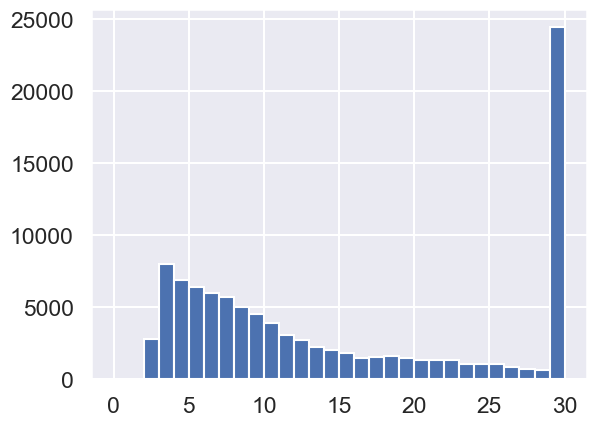

In [31]:
pattern = "2D Packing MIP with Time Limit (\d*\.?\d*) \[s\]"
x = df["raw"].str.extract(pattern).cast(pl.Float32)
plt.hist(x, bins=np.arange(0, 31, 1));

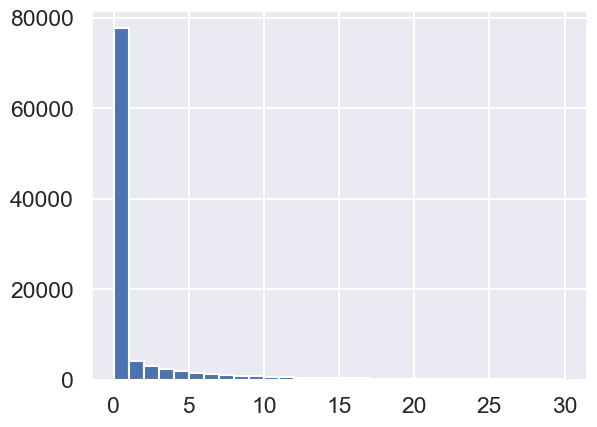

In [39]:
pattern = "- after (\d*\.?\d*) \[s\]"
y = mip_improvements.list[-1].str.extract(pattern).cast(pl.Float32)
plt.hist(y, bins=np.arange(0, 31, 1));

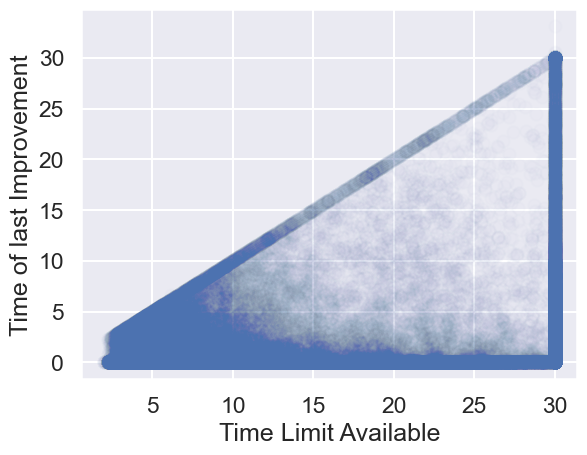

In [46]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
#plt.xscale("log")
#plt.yscale("log")

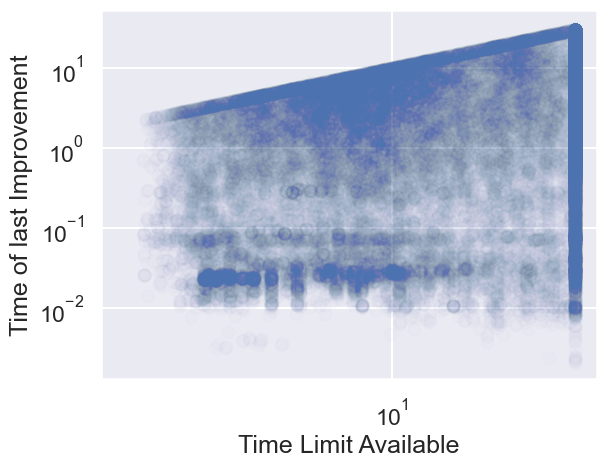

In [47]:
plt.scatter(x, y, alpha = 0.01);
plt.xlabel("Time Limit Available")
plt.ylabel("Time of last Improvement");
plt.xscale("log")
plt.yscale("log")